In [13]:
import os
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg
from os import path
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
import anndata as ad
%load_ext autoreload
%autoreload 2
%matplotlib inline

scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 pynndescent==0.5.10
squidpy==1.2.3
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
section_id ='151673'    
input_dir = os.path.join('/mnt/disk1/xzhou/data/spatial_3D/DLPFC/', section_id)
adata_st = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
adata_st.var_names_make_unique(join="++")

# read the annotation
Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
Ann_df[Ann_df.isna()] = "unknown"
adata_st.obs['Ground Truth'] = Ann_df.loc[adata_st.obs_names, 'Ground Truth'].astype('category') 

#'Ground Truth' 是原始列名，你需要将其改为 'cell_type'
adata_st.obs.rename(columns={'Ground Truth': 'cell_type'}, inplace=True)

In [36]:
ad_sp = adata_st.copy()
ad_sp

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'cell_type_colors'
    obsm: 'spatial'

In [38]:
ad_sc = ad.read_h5ad("/mnt/disk1/xzhou/data/multi-omics/DLPFC_scRNA/GSE144136/GSE144136.h5ad")

In [56]:
sc.pp.normalize_total(ad_sc)
sc.pp.log1p(ad_sc)
sc.pp.scale(ad_sc)
sc.tl.pca(ad_sc, n_comps=100, svd_solver="auto")

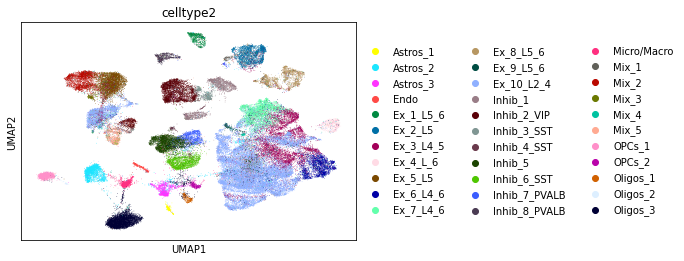

In [57]:
sc.pp.neighbors(ad_sc, metric="cosine")
sc.tl.umap(ad_sc)
sc.pl.umap(ad_sc, color="celltype2")

In [61]:
sc.tl.leiden(ad_sc)

In [71]:
ad_sc.obs.celltype2.value_counts()

celltype2
Ex_10_L2_4       23517
Ex_3_L4_5         5919
Oligos_3          5543
Inhib_2_VIP       4197
Ex_7_L4_6         3810
Ex_5_L5           3663
Inhib_5           3255
Astros_2          2729
Ex_6_L4_6         2470
Mix_2             2271
Ex_2_L5           2120
Inhib_6_SST       2118
Inhib_1           2066
Mix_5             1941
Ex_8_L5_6         1890
OPCs_1            1773
Micro/Macro       1327
Inhib_7_PVALB     1227
Astros_3          1094
Inhib_3_SST        883
Ex_1_L5_6          732
Inhib_8_PVALB      670
Ex_4_L_6           617
Mix_4              544
OPCs_2             490
Mix_3              416
Endo               340
Oligos_1           303
Mix_1              250
Ex_9_L5_6          238
Astros_1           234
Inhib_4_SST        191
Oligos_2            48
Name: count, dtype: int64

In [73]:
ad_sp.obs.cell_type.value_counts()

cell_type
Layer_3    989
Layer_6    692
Layer_5    673
WM         513
Layer_1    273
Layer_2    253
Layer_4    218
unknown     28
Name: count, dtype: int64

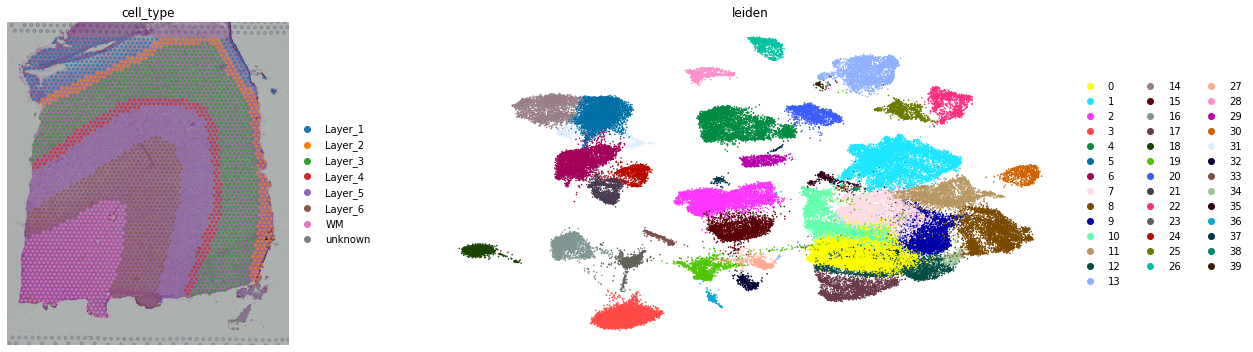

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sc.pl.spatial(
    ad_sp, color="cell_type", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    ad_sc, color="leiden", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

In [ ]:
sc.tl.rank_genes_groups(ad_sc, groupby="leiden", use_raw=False)
markers_df = pd.DataFrame(ad_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

In [ ]:
tg.pp_adatas(ad_sc, ad_sp, genes=markers)

In [ ]:
ad_map = tg.map_cells_to_space(ad_sc, ad_sp,
    mode="cells",
#     mode="clusters",
#     cluster_label='cell_subclass',  # .obs field w cell types
    density_prior='rna_count_based',
    num_epochs=500,
    device="cuda:0",
#     device='cpu',
)

In [ ]:
ad_map

In [ ]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))
tg.plot_cell_annotation_sc(adata_st, annotation_list,perc=0.02)

In [ ]:
tg.plot_training_scores(ad_map, bins=20, alpha=.5)

In [ ]:
ad_map.uns['train_genes_df']

In [ ]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)
ad_ge

In [ ]:
genes = ['rragb', 'trim17', 'eno1b']
ad_map.uns['train_genes_df'].loc[genes]

In [ ]:
tg.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

In [ ]:
genes=['loc102633833', 'gm5700', 'gm8292']
tg.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

In [ ]:
(ad_ge.var.is_training == False).sum()

In [ ]:
df_all_genes = tg.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
df_all_genes

In [ ]:
from tangram import utils as ut
def plot_auc(df_all_genes, test_genes=None):
    """
        Plots auc curve which is used to evaluate model performance.
    
    Args:
        df_all_genes (Pandas dataframe): returned by compare_spatial_geneexp(adata_ge, adata_sp); 
        test_genes (list): list of test genes, if not given, test_genes will be set to genes where 'is_training' field is False

    Returns:
        None
    """
    metric_dict, ((pol_xs, pol_ys), (xs, ys)) = ut.eval_metric(df_all_genes, test_genes)
    
    fig = plt.figure()
    plt.figure(figsize=(6, 5))

    plt.plot(pol_xs, pol_ys, c='r')
    sns.scatterplot(x=xs, y=ys, alpha=0.5, edgecolors='face')
        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.gca().set_aspect(.5)
    plt.xlabel('score')
    plt.ylabel('spatial sparsity')
    plt.tick_params(axis='both', labelsize=8)
    plt.title('Prediction on test transcriptome')
    
    textstr = 'auc_score={}'.format(np.round(metric_dict['auc_score'], 3))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    # place a text box in upper left in axes coords
    plt.text(0.03, 0.1, textstr, fontsize=11, verticalalignment='top', bbox=props);

    
# Colors used in the manuscript for deterministic assignment.
mapping_colors = {
    "L6 CT": (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
    "L6 IT": (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
    "L5/6 NP": (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
    "L6b": "#0000c2ff",
    "L2/3 IT": (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
    "L5 IT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5 ET": (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
    "Oligo": (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
    "Vip": (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
    "Astro": "#ffdd55ff",
    "Micro-PVM": "#000000ff",
    "Pvalb": (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
    "Lamp5": (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
    "Sst": (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
    "Sst Chodl": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    "Sncg": (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
    "Peri": (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
    "VLMC": (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
    "Endo": (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
    "Meis2": "#FFA500ff",
    "SMC": "#000000ff",
    "L6 PT": "#4682B4ff",
    "L5 PT": "#a1ed7bff",
    "L5 NP": "#6B8E23ff",
    "L4": "#d61f1dff",
    "Macrophage": "#2b2d2fff",
    "CR": "#000000ff",
}

In [ ]:
# sns.scatterplot(data=df_all_genes, x='score', y='sparsity_sp', hue='is_training', alpha=.5);  # for legacy
plot_auc(df_all_genes)

In [ ]:
genes=['tfap2b', 'zic4']
tg.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

In [ ]:
genes = ['cd34', 'rasal1']
tg.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

In [ ]:
genes = ['gm33027', 'gm5431']
tg.plot_genes_sc(genes[:5], adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

In [ ]:
sq.im.process(img=img, layer="image", method="smooth")
sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0,
)

In [ ]:
inset_y = 1500
inset_x = 1700
inset_sy = 400
inset_sx = 500

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0], title=""
)
axs[0].set_title("Clusters", fontdict={"fontsize": 20})
sf = adata_st.uns["spatial"]["V1_Adult_Mouse_Brain_Coronal_Section_2"]["scalefactors"][
    "tissue_hires_scalef"
]
rect = mpl.patches.Rectangle(
    (inset_y * sf, inset_x * sf),
    width=inset_sx * sf,
    height=inset_sy * sf,
    ec="yellow",
    lw=4,
    fill=False,
)
axs[0].add_patch(rect)

axs[0].axes.xaxis.label.set_visible(False)
axs[0].axes.yaxis.label.set_visible(False)

axs[1].imshow(
    img["image"][inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx, 0, 0]
    / 65536,
    interpolation="none",
)
axs[1].grid(False)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("DAPI", fontdict={"fontsize": 20})

crop = img["segmented_watershed"][
    inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx
].values.squeeze(-1)
crop = skimage.segmentation.relabel_sequential(crop)[0]
cmap = plt.cm.plasma
cmap.set_under(color="black")
axs[2].imshow(crop, interpolation="none", cmap=cmap, vmin=0.001)
axs[2].grid(False)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Nucleous segmentation", fontdict={"fontsize": 20});

In [ ]:
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_st,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

In [ ]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["cluster", "cell_count"], frameon=False)

In [ ]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="constrained",
    target_count=adata_st.obs.cell_count.sum(),
    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
#     device="cuda:0",
    device='cpu',
)

In [ ]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))
tg.plot_cell_annotation_sc(adata_st, annotation_list, perc=0.02)

In [ ]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)
df_all_genes = tg.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
plot_auc(df_all_genes);

In [ ]:
tg.create_segment_cell_df(adata_st)
adata_st.uns["tangram_cell_segmentation"].head()

In [ ]:
tg.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="cell_subclass",
)
adata_st.obsm["tangram_ct_count"].head()

In [ ]:
adata_segment = tg.deconvolve_cell_annotations(adata_st)
adata_segment.obs.head()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.spatial(
    adata_segment,
    color="cluster",
    size=0.4,
    show=False,
    frameon=False,
    alpha_img=0.2,
    legend_fontsize=20,
    ax=ax,
)